In [41]:
import os
from matplotlib import pyplot as plt
import torch
import numpy as np
from methods import load_module
from sims import BaseVAESim, get_sim


def get_frame_pred(init_frame: torch.Tensor, ts: np.ndarray, 
                   sim_obj: BaseVAESim, method: str, version: int, 
                   ncom: int, nstates: int) -> torch.Tensor:
    # get the frames predicted by the given method
    # init_frames: (2, nchannels, height, width)
    # load the module
    ckpt_path = f"lightning_logs/version_{version}/checkpoints/"
    top_epoch = sorted(os.listdir(ckpt_path))[-1]
    print(sorted(os.listdir(ckpt_path)))
    ckpt_path = os.path.join(ckpt_path, top_epoch)
    print(ckpt_path)
    module = load_module(method, ckpt_path=ckpt_path, data_shape=sim_obj.data_shape, ncom=ncom, nlatent_dim=nstates, dt=1e-2)
    module = module.to(torch.device("cpu"))
    module.eval()
    
    init_frame = init_frame.to(module.device)

    # get the initial zstates
    init_zstate = module.encode(init_frame[None]).squeeze(0)  # (nlatent_dim,)

    # simulate the dynamics and then decode the latent var
    zstates = torch.as_tensor(module.time_series(init_zstate.detach().cpu().numpy(), ts), dtype=torch.float32)  # (nt, nlatent_dim)
    frame_pred = module.decode(zstates)  # (nt, nchannels, height, width)
    return frame_pred

class Args:
    parse = lambda x: x.split(" ")
    to_int = lambda l: [int(item) for item in l] 
    sim = "two-body"
    methods = parse("comet comet")
    nstates = to_int(parse("10 10"))
    ncoms = to_int(parse("9 0"))
    versions = to_int(parse("0 1"))
    names = parse("COMET NODE")
    seed = 2
    tmax = 200
    figname = "figure_1.png"
    



args = Args()

torch.manual_seed(args.seed)  # the seed must be different from main.py
np.random.seed(args.seed)

ndset = 1
ts = np.linspace(0, args.tmax, 101)
sim = args.sim

# get the simulation information
sim_obj = get_sim(sim)
assert len(args.methods) == len(args.versions) == len(args.nstates) == len(args.ncoms) == len(args.names)

# simulate the dynamics
params_i = [p[0] for p in sim_obj.get_params_list(ndset)]
params = params_i[:]
frames = torch.as_tensor(sim_obj.simulate(*params, ts), dtype=torch.float32)  # (nt, 3, nchannels, height, width)
init_frame = frames[0, :2]  # (2, nchannels, height, width)

In [42]:
# get the simulated frames
n = len(args.methods)
all_frames = {"Ground truth": frames[:, 0]}
for i in range(n):
    ncom = args.ncoms[i]
    nstates = args.nstates[i]
    method = args.methods[i]
    version = args.versions[i]
    name = args.names[i]
    
    # get the frames predicted by the methods
    frame_preds = get_frame_pred(init_frame, ts, sim_obj, method, version, ncom, nstates)
    all_frames[name] = frame_preds

# plot the images
nimgs = 10
title_fontsize = 25
name_fontsize = 25
nframes = len(all_frames)
plt.figure(figsize=(3 * nimgs, 3 * nframes))
for irow, (name, frame_pred) in enumerate(all_frames.items()):
    steps = frame_pred.size(0) // nimgs
    for ifig in range(nimgs):
        print(irow, ifig)
        i = ifig * steps
        plt.subplot(nframes, nimgs, irow * nimgs + ifig + 1)
        toshow = sim_obj.to_imshow(frame_pred[i])
        plt.imshow(toshow)
        if irow == 0:
            plt.title("t = %.1f" % ts[i], fontsize=title_fontsize)
        if ifig == 0:
            plt.ylabel(name, fontsize=name_fontsize)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.savefig(args.figname)
plt.close()

['epoch=496-step=6958.ckpt', 'epoch=615-step=8624.ckpt', 'epoch=7939-step=111160.ckpt']
lightning_logs/version_0/checkpoints/epoch=7939-step=111160.ckpt


/workspace/shubham/anaconda3/envs/cfps/lib/python3.10/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/workspace/shubham/anaconda3/envs/cfps/lib/python3.10/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated

['epoch=276-step=3878.ckpt', 'epoch=496-step=6958.ckpt', 'epoch=7975-step=111664.ckpt']
lightning_logs/version_1/checkpoints/epoch=7975-step=111664.ckpt
0 0
0 1
0 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 3
2 4
2 5
2 6
2 7
2 8
2 9


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

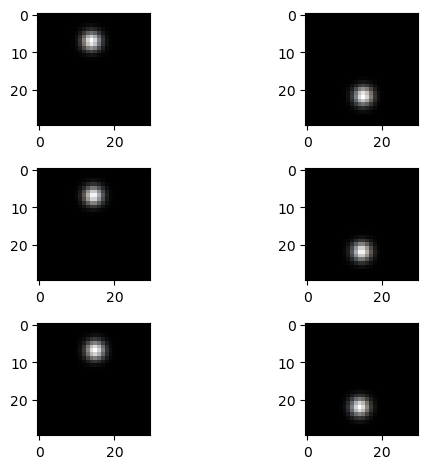

In [34]:
ar = np.load('check_data.npy')
fig, axs = plt.subplots(3, 2) 

for i in range(3):
    sample = rearrange(ar[i+75], "C B H W -> B C H W")
    image_t0 = rearrange(sample[0], "C H W -> H W C")
    image_t1 = rearrange(sample[1], "C H W -> H W C")
    axs[i, 0].imshow(image_t0)
    axs[i, 1].imshow(image_t1)
fig.tight_layout()
plt.show()

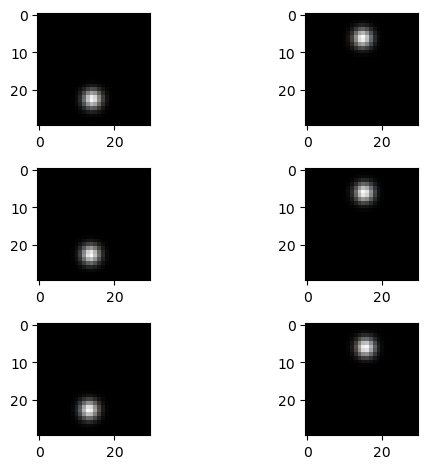

In [35]:
ar = np.load('check_data_1.npy')
fig, axs = plt.subplots(3, 2) 

for i in range(3):
    sample = rearrange(ar[i+75], "C B H W -> B C H W")
    image_t0 = rearrange(sample[0], "C H W -> H W C")
    image_t1 = rearrange(sample[1], "C H W -> H W C")
    axs[i, 0].imshow(image_t0)
    axs[i, 1].imshow(image_t1)
fig.tight_layout()
plt.show()

In [45]:
from dataset import Obj3DDataset
train_ds = Obj3DDataset()
frames = train_ds[0]

In [46]:
print(frames.shape)

torch.Size([2, 3, 128, 128])


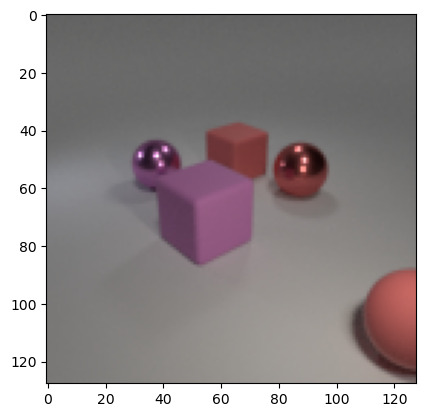

In [48]:
# 2, 3, 128, 128
f0 = rearrange(frames[0], 'C H W -> H W C')
f1 = rearrange(frames[1], 'C H W -> H W C')
plt.imshow(f0.numpy())

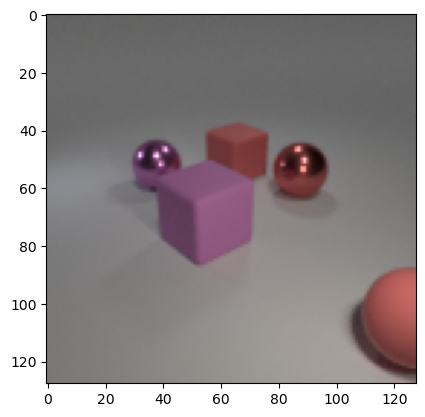

In [49]:
plt.imshow(f1.numpy())